In [13]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize

In [14]:
def define_axes(X):
  min1,max1 = X[:,0].min(),X[:,0].max()
  min2,max2 = X[:,1].min(),X[:,1].max()
  return [min1-.1,max1+.1,min2-.1,max2+.1]
  
def plotdataset(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

def plotPredictions(clf,X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X = np.c_[x0.ravel(),x1.ravel()]
  ypred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha = 0.2)

In [15]:
def criadatasetxor(n=1000):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y = np.array(y%2,dtype=int)
  return X,y

In [16]:
Xm,ym = criadatasetxor(n=1000)

In [17]:
X = Xm
y = ym

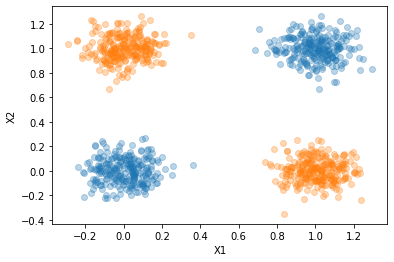

In [18]:
plotdataset(X,y)

In [8]:
class trainingalgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass
    
class PseudoInversa(trainingalgorithm):
  def getW(self,X,y):
    return np.linalg.pinv(X) @ y

In [9]:
def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

def tanh(a):
  return expit(a)*2-1

class FixedWeights():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.training = PseudoInversa()
  
  def fit(self, X, y):
    self.wih = np.array([[1.75, 0.95, -0.9], [-1.75, 0.85, -0.9]]).T
    H = self.activation(includebias(X) @ self.wih)
    Hb = includebias(H)
    self.who = self.training.getW(Hb,y)

  def predict(self, X, g=None):
    Xb = includebias(X)
    H = self.activation(Xb @ self.wih)
    Hb = includebias(H)
    return Hb @ self.who


class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm=FixedWeights()):
    # training algorithm
    self.training_algorithm = training_algorithm
   
  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)

  def predict(self, X, y=None):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <=2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

In [19]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.9)

In [20]:
model = MLP()

model.fit(Xtr,ytr)

ypred = model.predict(Xtr,ytr)

sum(ytr == ypred)/len(ytr)

0.99

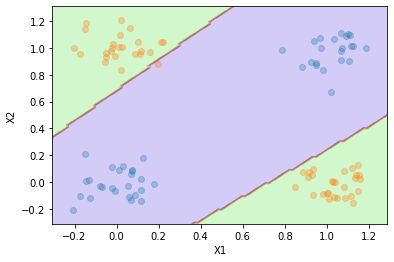

In [21]:
plotdataset(Xtr,ytr)
plotPredictions(model,Xtr)

In [22]:
ypred = model.predict(Xte,yte)
sum(yte== ypred)/len(yte)

0.99

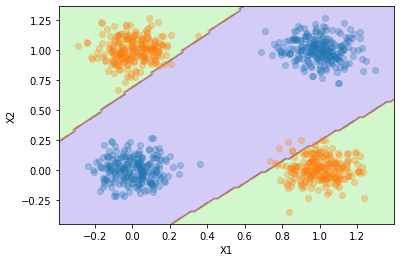

In [23]:
plotdataset(Xte,yte)
plotPredictions(model,Xte)